In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_coro_2dm_34 as fresnel
import apra_pop_models.rmad_2dm as rmad
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc_2dm as adefc
from scipy.optimize import minimize


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


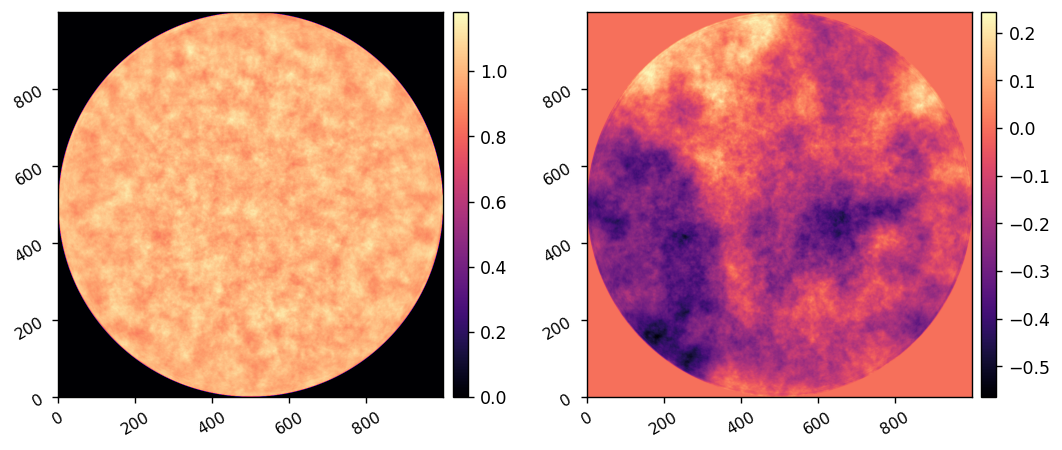

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

WFE = I.calc_pupil()
imshow2(xp.abs(WFE), xp.angle(WFE))

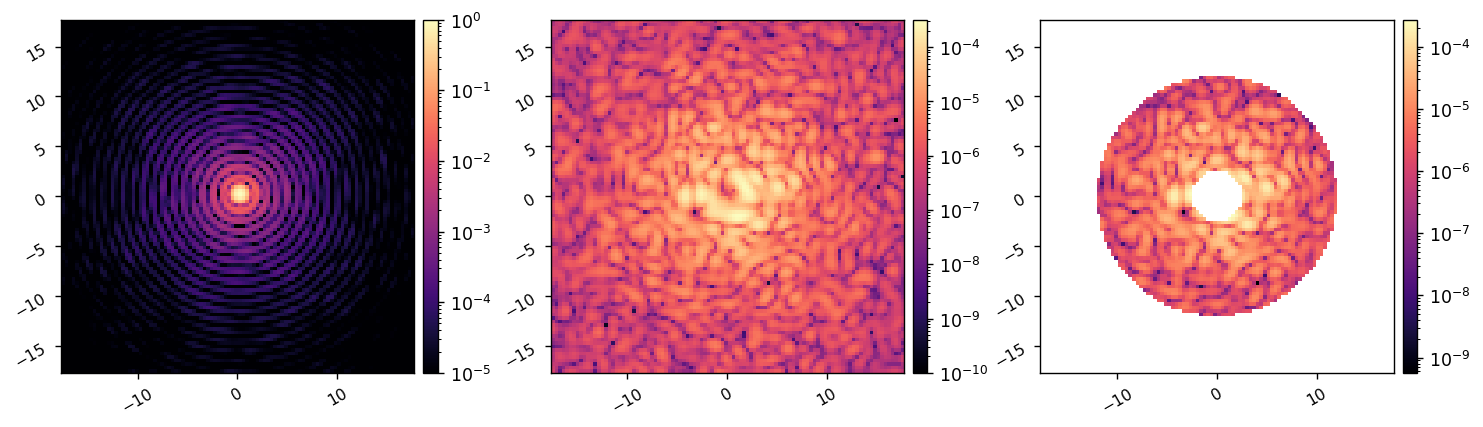

In [8]:
reload(rmad)
I = rmad.MODEL()
I.WFE = WFE
I.d_dm1_dm2 = 0*u.mm
# I.flip_dm = True
# I.flip_lyot = True

iwa = 2.5
owa = 12
edge = None
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=edge, rotation=rot)

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow3(ref_psf, ref_coro_im, ref_coro_im * control_mask, 
        pxscl=I.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


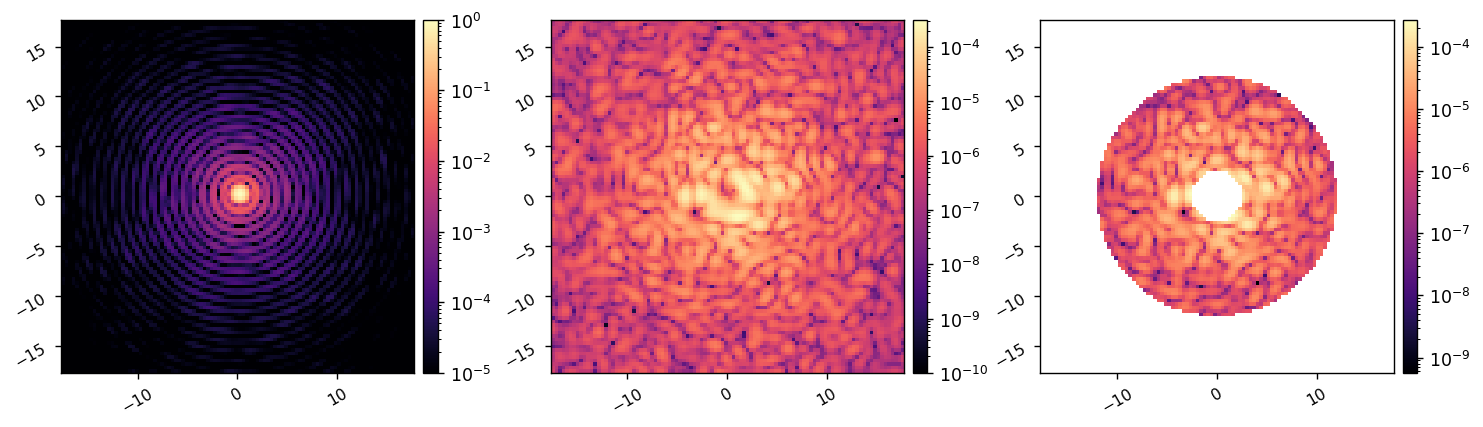

In [9]:
reload(rmad)
reload(props)
M = rmad.MODEL()
M.WFE = WFE
M.d_dm1_dm2 = 100*u.mm
# M.flip_dm = True
# M.flip_lyot = True

M.use_vortex = False
model_psf = M.snap()
M.Imax_ref = xp.max(model_psf)
model_psf /= M.Imax_ref
M.use_vortex = True
model_coro_im = M.snap()

imshow3(model_psf, model_coro_im, model_coro_im * control_mask,
        pxscl=M.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


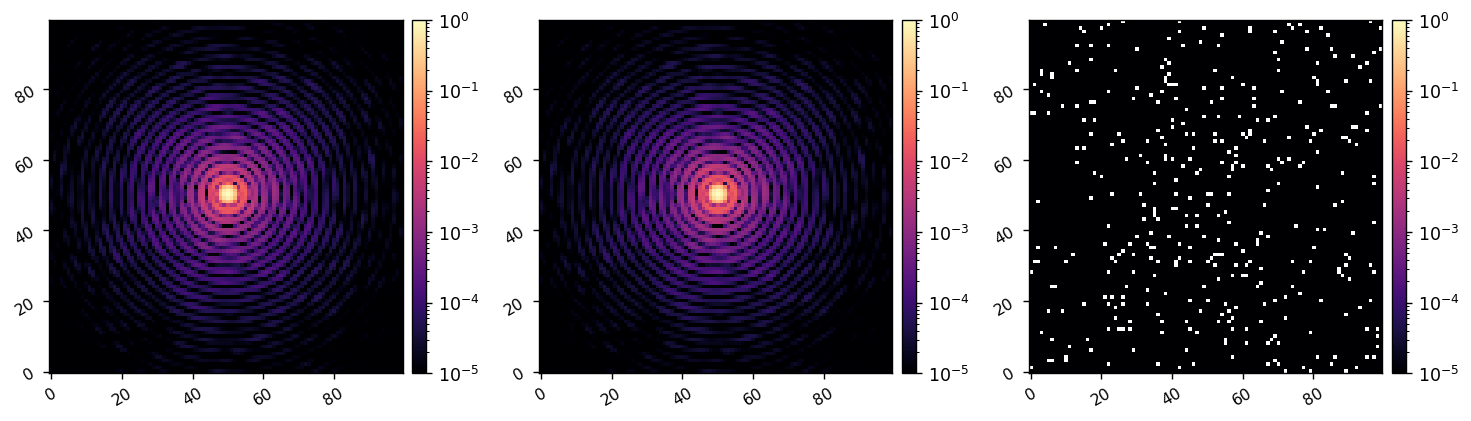

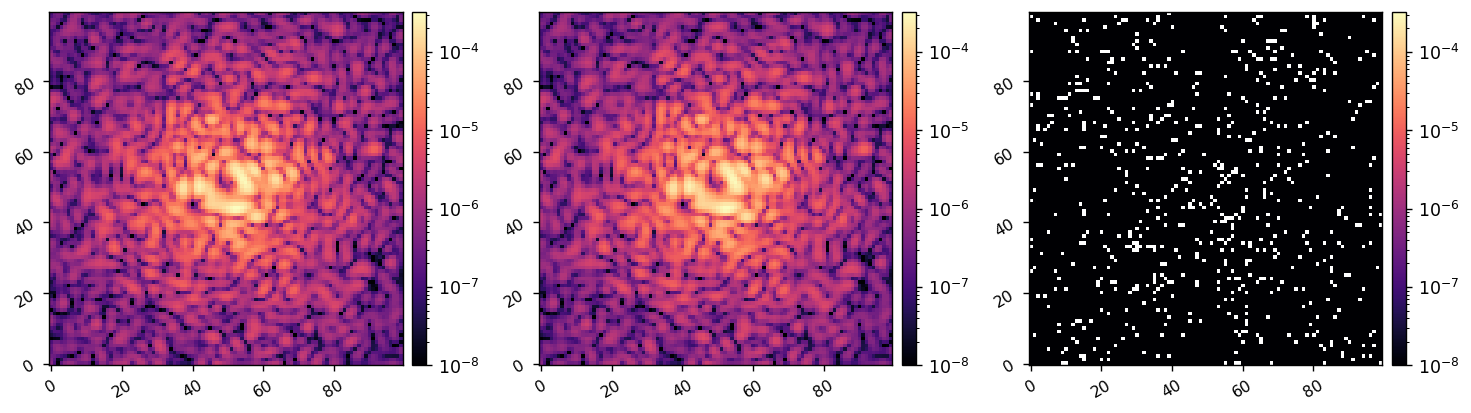

In [10]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

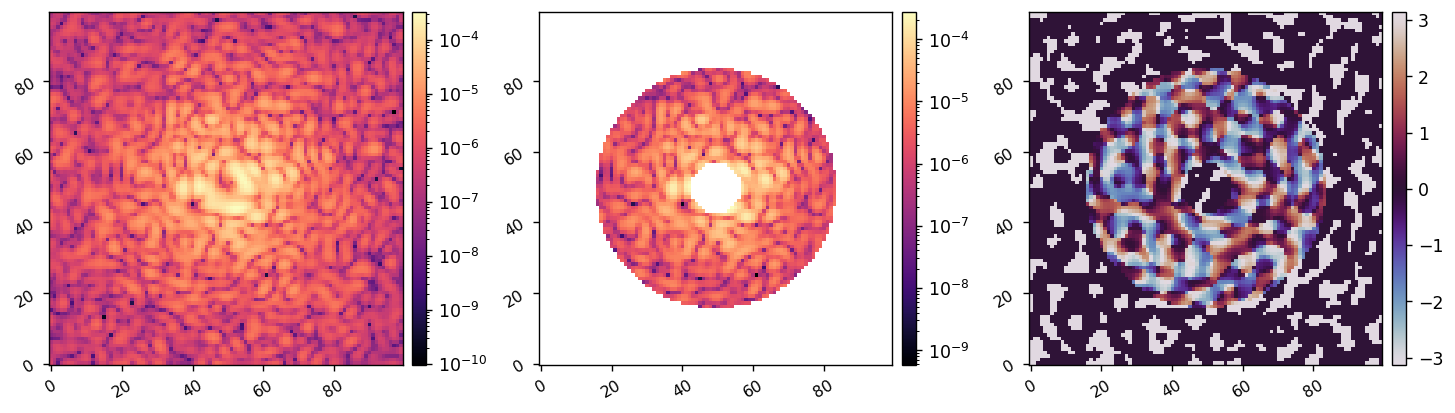

	Cost-function J_delE: 0.038
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.038
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  3.58704D+06
	Cost-function J_delE: 0.004
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.038
	Total cost-function value: 62065334530.936



 This problem is unconstrained.


	Cost-function J_delE: 0.011
	Cost-function J_c: 23.453
	Cost-function normalization factor: 0.038
	Total cost-function value: 615.308

	Cost-function J_delE: 0.222
	Cost-function J_c: 1.460
	Cost-function normalization factor: 0.038
	Total cost-function value: 44.100

	Cost-function J_delE: 0.865
	Cost-function J_c: 0.124
	Cost-function normalization factor: 0.038
	Total cost-function value: 25.936

	Cost-function J_delE: 4.524
	Cost-function J_c: 0.012
	Cost-function normalization factor: 0.038
	Total cost-function value: 118.970

	Cost-function J_delE: 0.740
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.038
	Total cost-function value: 19.408

	Cost-function J_delE: 0.011
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.038
	Total cost-function value: 0.283


At iterate    1    f=  2.82778D-01    |proj g|=  9.70885D+05
	Cost-function J_delE: 0.007
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.038
	Total cost-function value: 0.177


In [11]:
reload(rmad)
acts = xp.zeros(M.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm1(rmad.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
I.set_dm2(rmad.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
coro_im = I.snap()
E_ab = I.calc_wf() * control_mask
imshow3(coro_im, xp.abs(E_ab)**2, xp.angle(E_ab), lognorm1=True, lognorm2=True, cmap3='twilight')

r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_ab, r_cond, control_mask, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

1.1021687350804017e-05 0.00010430582638638667


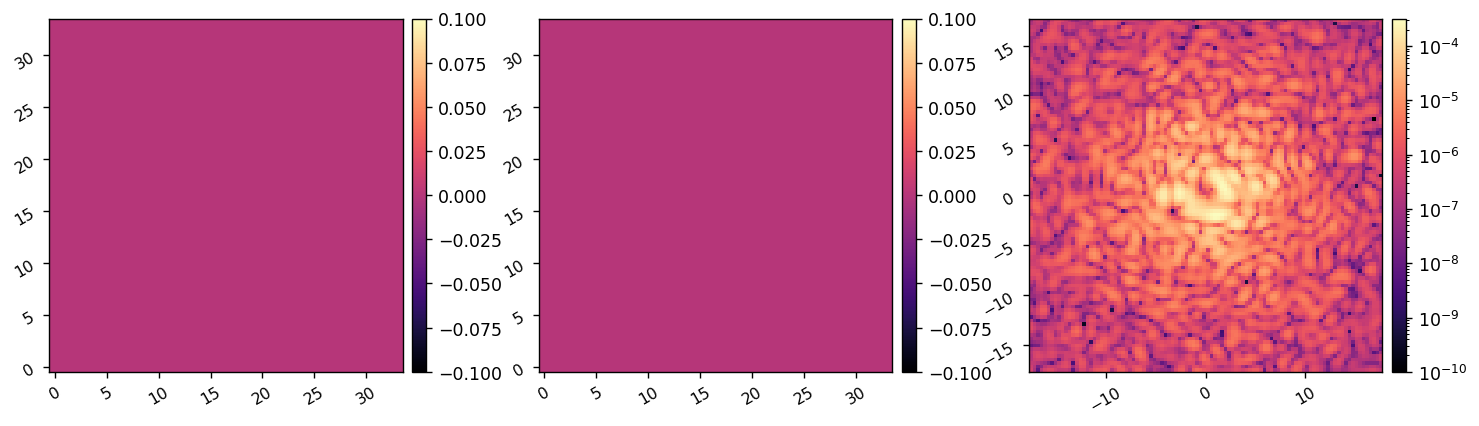

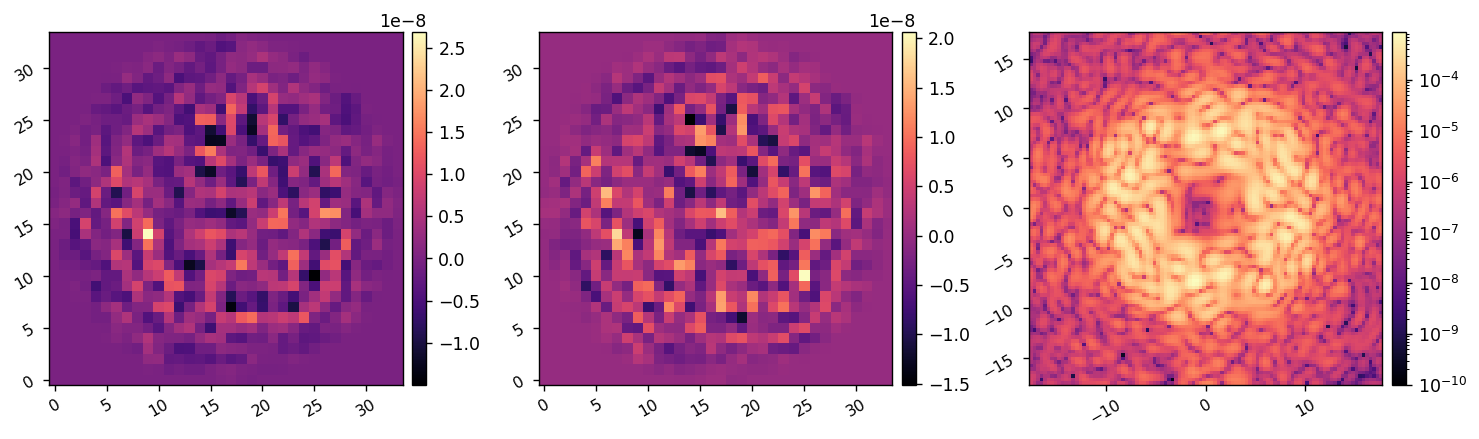

In [12]:
old_dm1 = rmad.acts_to_command(acts[:M.Nacts//2], I.dm_mask)
old_dm2 = rmad.acts_to_command(acts[M.Nacts//2:], I.dm_mask)
del_dm1 = rmad.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = rmad.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.set_dm1(old_dm1 + del_dm1)
I.set_dm2(old_dm2 + del_dm2)
new_im = I.snap()

print(xp.mean(coro_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamD, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamD, vmin3=1e-10,)


In [71]:
I.zero_dms()
all_ims = []
all_efs = []
all_commands = []

Running estimation algorithm ...
Computing EFC command with L-BFGS


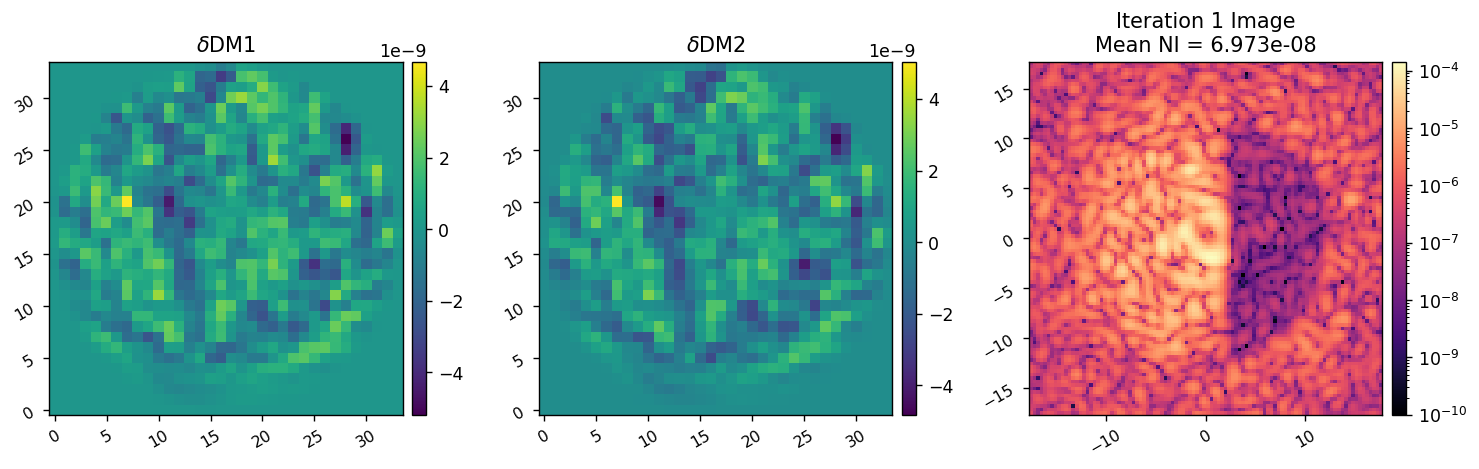

Running estimation algorithm ...
Computing EFC command with L-BFGS


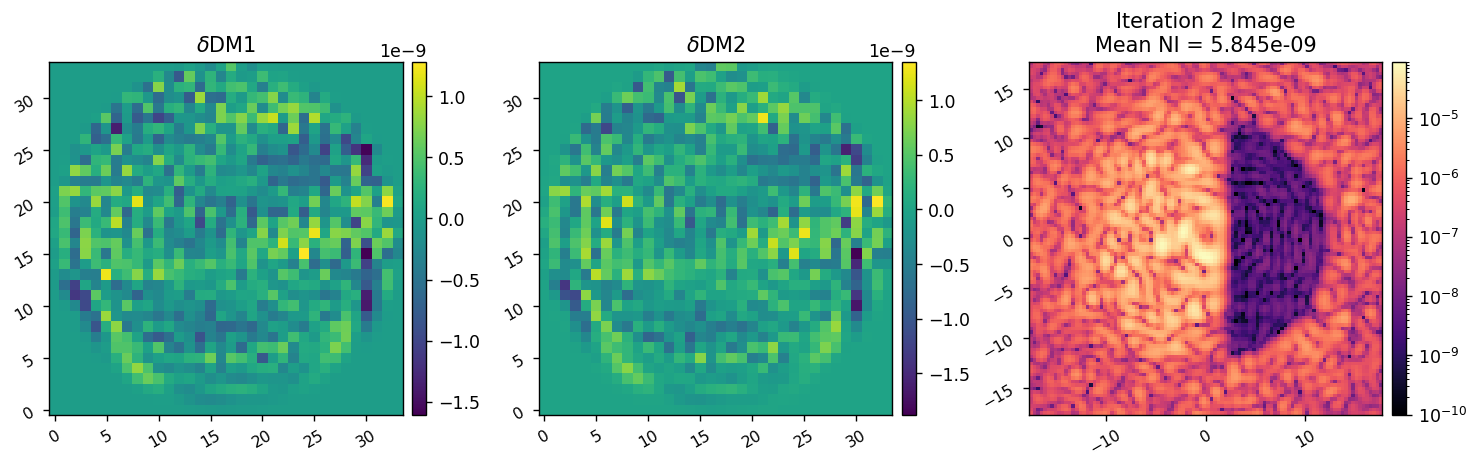

Running estimation algorithm ...
Computing EFC command with L-BFGS


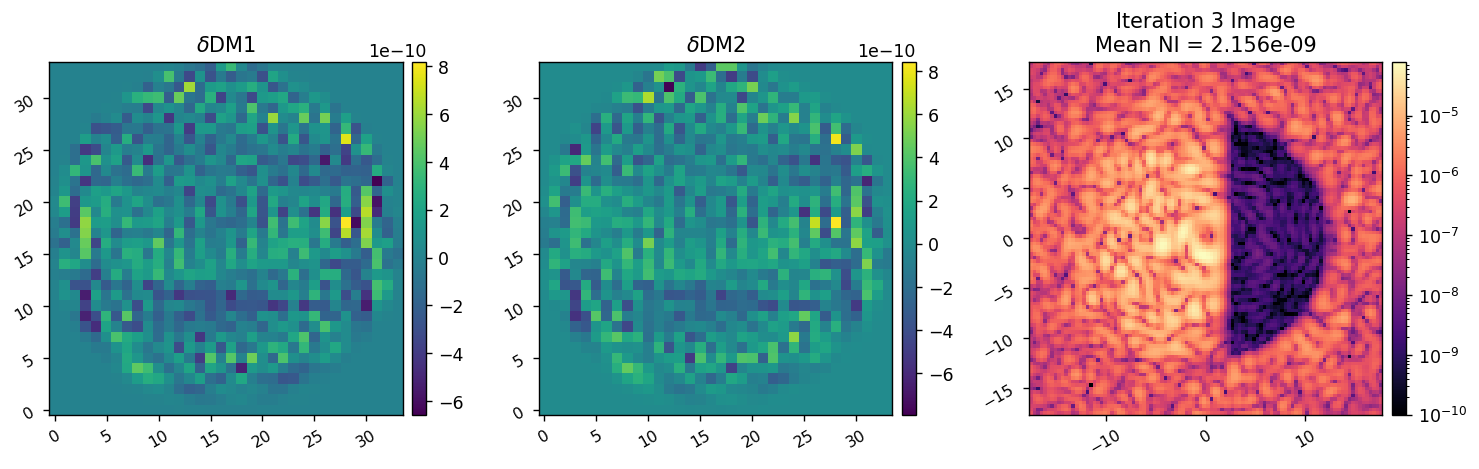

In [72]:
reload(rmad)
reload(adefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = adefc.run(I, M, 
                                            rmad.val_and_grad, control_mask, 
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

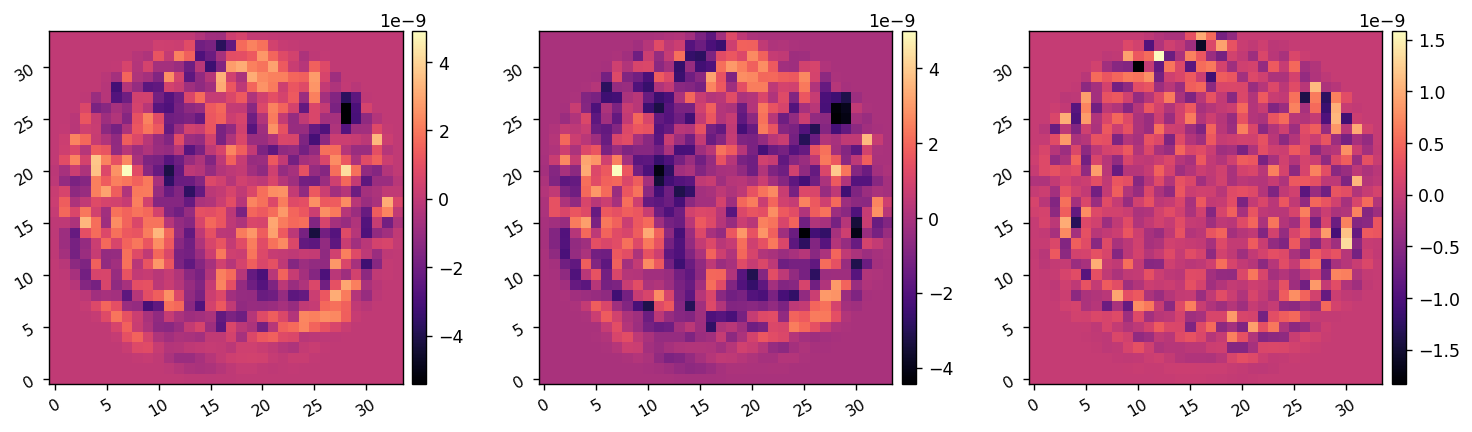

In [75]:
dm1 = all_commands[-1][0]
dm2 = all_commands[-1][1]
imshow3(dm1, dm2, dm1-dm2)